In [1]:
import mint
import numpy
import netCDF4

In [2]:
src_grid = mint.Grid()
src_grid.loadFrom2DUgrid('../../data/lfric_diag_wind.nc$Mesh2d')
# required for the cubc-sphere grid
src_grid.setFlags(fixLonAcrossDateline=1, averageLonAtPole=1)

In [3]:
# get the velocities
nc = netCDF4.Dataset('../../data/lfric_diag_wind.nc')
u1 = nc.variables['u1'][:]
u2 = nc.variables['u2'][:]

In [4]:
# compute integrals of the velocity over the edges (flows)
lon = nc.variables['Mesh2d_node_x']
lat = nc.variables['Mesh2d_node_y']
edge_node_connect = nc.variables['Mesh2d_edge_nodes']
ibeg = edge_node_connect[:, 0]
iend = edge_node_connect[:, 1]

lonbeg = lon[ibeg]
lonend = lon[iend]
lonmid = (lonbeg + lonend)*0.5

latbeg = lat[ibeg]
latend = lat[iend]
latmid = (latbeg + latend)*0.5

nedge = lonbeg.shape[0]

rhobeg = numpy.cos(latbeg*numpy.pi/180.)
xyzbeg = numpy.zeros((nedge, 3), numpy.float64)
xyzbeg[:, 0] = rhobeg * numpy.cos(lonbeg*numpy.pi/180.)
xyzbeg[:, 1] = rhobeg * numpy.sin(lonbeg*numpy.pi/180.)
xyzbeg[:, 2] = numpy.sin(latbeg*numpy.pi/180.)

rhoend = numpy.cos(latend*numpy.pi/180.)
xyzend = numpy.zeros((nedge, 3), numpy.float64)
xyzend[:, 0] = rhobeg * numpy.cos(lonend*numpy.pi/180.)
xyzend[:, 1] = rhobeg * numpy.sin(lonend*numpy.pi/180.)
xyzend[:, 2] = numpy.sin(latend*numpy.pi/180.)


lambda_hat = numpy.zeros((nedge, 3), numpy.float64)
lambda_hat[:, 0] = - numpy.sin(lonmid*numpy.pi/180.)
lambda_hat[:, 1] = numpy.cos(lonmid*numpy.pi/180.)

theta_hat = numpy.zeros((nedge, 3), numpy.float64)
theta_hat[:, 0] = - numpy.sin(latmid*numpy.pi/180.) * numpy.cos(lonmid*numpy.pi/180.)
theta_hat[:, 1] = - numpy.sin(latmid*numpy.pi/180.) * numpy.sin(lonmid*numpy.pi/180.)
theta_hat[:, 2] = numpy.cos(latmid*numpy.pi/180.)

xyzdiff = xyzend - xyzbeg

In [5]:
print(xyzdiff.shape)

(3072, 3)


In [6]:
ue_integrated = numpy.zeros(u1.shape, numpy.float64)
uvec = numpy.zeros((nedge, 3), numpy.float64)
for i0 in range(u1.shape[0]):
    for i1 in range(u1.shape[1]):
        for k in range(3):
            uvec[:, k] = u1[i0, i1, :] * lambda_hat[:, k] + u2[i0, i1, :] * theta_hat[:, k]
        ue_integrated[i0, i1, :] = numpy.sum(uvec*xyzdiff, axis=1)

In [12]:
# create target grid
llon, llat = numpy.meshgrid(numpy.linspace(-180, 180, 100), numpy.linspace(-80, 80, 50))
ntarget = llon.shape[0] * llon.shape[1]
target_points = numpy.zeros((ntarget, 3), numpy.float64)
target_points[:, 0] = llon.flat
target_points[:, 1] = llat.flat

In [13]:
# create a vector interpolator
vi = mint.VectorInterp()
vi.setGrid(src_grid)
vi.buildLocator()
vi.findPoints(target_points)
edgeVectors = vi.getEdgeVectors(ue_integrated)

Some target lines fall outside the grid.


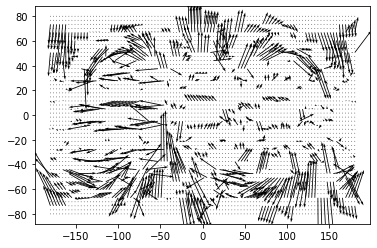

In [14]:
from matplotlib import pylab
pylab.quiver(target_points[:, 0], target_points[:, 1], edgeVectors[:, 0], edgeVectors[:, 1])
pylab.show()